## 1. Se importan las librerias

In [2]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import keras
from keras.utils import to_categorical
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from keras import backend as K
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, plot_confusion_matrix
# Agregadas
from sklearn.datasets import make_classification
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow.keras.utils import img_to_array
import cv2
from sklearn.preprocessing import LabelBinarizer
import pickle
from focal_loss import BinaryFocalLoss
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import pandas as pd

## 2. Parametrizaciones

In [3]:
#dirname = os.path.join("../FotosOriginales")
#dirname = os.path.join("../FotosAumentadas")
dirname = os.path.join("FotosCombinadas")
imgpath = dirname + os.sep 
HEIGHT=128
WIDTH=128
DEPTH=3
DEFAULT_IMAGE_SIZE = tuple((WIDTH, HEIGHT))
INIT_LR = 1e-3
epochs = 30
batch_size = 16
inputShape = (HEIGHT, WIDTH, DEPTH)
chanDim = -1

## 3. Se cargan las imágenes

In [4]:
images = []
directories = []
dircount = []
prevRoot=''
cant=0

print("Leyendo imágenes de ",imgpath)

for root, dirnames, filenames in os.walk(imgpath):
    for filename in filenames:
        if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
            cant=cant+1
            filepath = os.path.join(root, filename)
            image = plt.imread(filepath)
            res = cv2.resize(image, dsize=(WIDTH, HEIGHT), interpolation=cv2.INTER_CUBIC)
            images.append(res)
            b = "Leyendo..." + str(cant)
            print (b, end="\r")
            if prevRoot !=root:
                print(root, cant)
                prevRoot=root
                directories.append(root)
                dircount.append(cant)
                cant=0
dircount.append(cant)

dircount = dircount[1:]
dircount[0]=dircount[0]+1
print('Directorios leidos:',len(directories))
print("Imagenes en cada directorio", dircount)
print("Imagenes en directorio NoSana", dircount[0])
print("Imagenes en directorio Sana", dircount[1])
print('Suma Total de imagenes en subdirs:',sum(dircount))

Leyendo imágenes de  FotosCombinadas/
FotosCombinadas/NoSana 1
FotosCombinadas/Sana 155
Directorios leidos: 2
Imagenes en cada directorio [156, 212]
Imagenes en directorio NoSana 156
Imagenes en directorio Sana 212
Suma Total de imagenes en subdirs: 368


## 4. Se crean etiquetas y clases

In [5]:
labels=[]
indice=0
for cantidad in dircount:
    for i in range(cantidad):
        labels.append(indice)
    indice=indice+1
print("Cantidad etiquetas creadas: ",len(labels))
etiquetas=[]
indice=0
for directorio in directories:
    name = directorio.split(os.sep)
    print(indice , name[len(name)-1])
    etiquetas.append(name[len(name)-1])
    indice=indice+1

y = np.array(labels)
X = np.array(images, dtype=np.uint8) #Lista a numpy

classes = np.unique(y)
nClasses = len(classes)
print('Número total de salidas : ', nClasses)
print('Clases de salida : ', classes)

Cantidad etiquetas creadas:  368
0 NoSana
1 Sana
Número total de salidas :  2
Clases de salida :  [0 1]


## 5. Distribución de clases

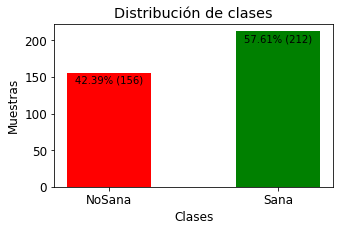

In [6]:
font = {'size'   : 12}
plt.rc('font', **font)

clases = list(etiquetas)
valores = list([dircount[0], dircount[1]])
fig = plt.figure(figsize = (5, 3))
 
plt.bar(clases, valores, color =["red", "green"], width = 0.5)
plt.xlabel("Clases")
plt.ylabel("Muestras")
plt.title("Distribución de clases")
plt.text(-0.2, dircount[0]-15,str(round(dircount[0]/(dircount[0]+dircount[1])*100,2)) + "% (" + str(dircount[0]) + ")", fontsize=10)
plt.text(0.8, dircount[1]-15, str(round(dircount[1]/(dircount[0]+dircount[1])*100,2)) + "% (" + str(dircount[1]) + ")", fontsize=10)
plt.show()

## 6. Se crean los sets de Entrenamiento y Test, Validación y Preprocesar

In [7]:
#Crear los grupos de entrenamiento y testing
train_X,test_X,train_Y,test_Y = train_test_split(X,y,test_size=0.2)
print('Training data shape : ', train_X.shape, train_Y.shape)
print('Testing data shape : ', test_X.shape, test_Y.shape)

train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X / 255.
test_X = test_X / 255.

# Cambia las etiquetas desde categorical a one-hot
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

# Muestra las etiquetas cambiadas desde category a one-hot
print('Etiqueta original:', train_Y[0])
print('Convertida a one-hot:', train_Y_one_hot[0])

train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)

print(train_X.shape,valid_X.shape,train_label.shape,valid_label.shape)

Training data shape :  (294, 128, 128, 3) (294,)
Testing data shape :  (74, 128, 128, 3) (74,)
Etiqueta original: 1
Convertida a one-hot: [0. 1.]
(235, 128, 128, 3) (59, 128, 128, 3) (235, 2) (59, 2)


## 7. Se crea la red

In [8]:
# Calculo de métrica F1
def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

model = Sequential()

# Modelo
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=inputShape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(nClasses, activation='softmax'))

model.summary()

#Funciones de pérdida
perd = "categorical_crossentropy"

#Optimizadores
opt = keras.optimizers.Adam(learning_rate=INIT_LR, decay=INIT_LR / epochs)

model.compile(loss=perd, optimizer=opt,metrics=['accuracy', f1_metric])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 32, 32, 32)        0

2022-12-11 20:30:07.589228: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 8. Se entrena la red

In [26]:
history = model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

# Se guarda el modelo
model.save("modelCombinadas-BASE.h5")

TypeError: unsupported operand type(s) for -: 'range' and 'int'

## 9. Análisis de métricas de rendimiento

In [10]:
y_pred = model.predict(test_X)
y_pred.shape
test_Y.shape
y_pred[0,:].sum()

3/3 [==============================] - 0s 42ms/step


1.0

## 10. Resultados obtenidos

In [27]:
test_eval = model.evaluate(test_X, test_Y_one_hot, verbose=1)

print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])
print('Test F1:', test_eval[2])

3/3 [==============================] - 0s 37ms/step - loss: 0.2928 - accuracy: 0.8784 - f1_metric: 0.8833
Test loss: 0.2928377091884613
Test accuracy: 0.8783783912658691
Test F1: 0.8833332657814026


## 11. Gráficos

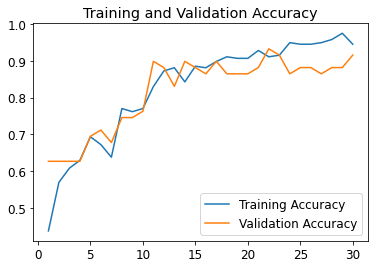

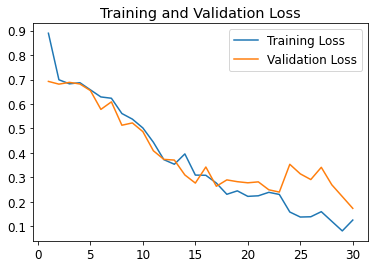

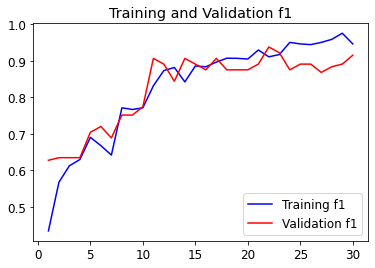

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

f1 = history.history['f1_metric']
val_f1 = history.history['val_f1_metric']

epochs = range(1, len(acc) + 1)

# Accuracy de los datos de entrenamiento y datos de prueba
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

# Pérdida de datos de entrenamiento y datos de prueba
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# F1 de los datos de entrenamiento y datos de prueba
plt.plot(epochs, f1, 'b', label='Training f1')
plt.plot(epochs, val_f1, 'r', label='Validation f1')
plt.title('Training and Validation f1')
plt.legend()
plt.show()

## 12. Matriz de confusión

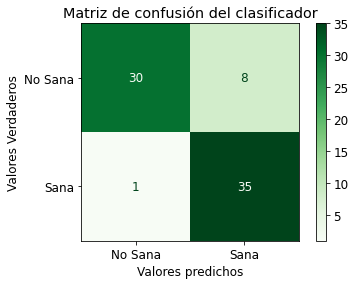

,0,1,accuracy,macro avg,weighted avg
precision,0.967742,0.813953,0.878378,0.890848,0.892926
recall,0.789474,0.972222,0.878378,0.880848,0.878378
f1-score,0.869565,0.886076,0.878378,0.877821,0.877597
support,38.000000,36.000000,0.878378,74.000000,74.000000


array([[8.5212582e-01, 1.4787415e-01],
       [9.9997687e-01, 2.3107303e-05],
       [1.8319525e-02, 9.8168051e-01],
       [9.6211126e-03, 9.9037886e-01],
       [9.9714988e-01, 2.8501523e-03],
       [9.7722089e-01, 2.2779129e-02],
       [1.3372353e-01, 8.6627644e-01],
       [2.0156702e-02, 9.7984332e-01],
       [1.0000000e+00, 3.5201493e-14],
       [6.7742117e-02, 9.3225783e-01],
       [2.0357147e-01, 7.9642850e-01],
       [1.4023229e-01, 8.5976768e-01],
       [9.9231517e-01, 7.6847998e-03],
       [5.3426415e-02, 9.4657362e-01],
       [3.8519552e-01, 6.1480445e-01],
       [9.9941504e-01, 5.8494532e-04],
       [9.9861097e-01, 1.3889875e-03],
       [8.6931735e-01, 1.3068269e-01],
       [9.0790853e-02, 9.0920913e-01],
       [9.9998212e-01, 1.7907534e-05],
       [1.5355144e-02, 9.8464483e-01],
       [2.8630066e-01, 7.1369934e-01],
       [5.3384191e-01, 4.6615812e-01],
       [7.7822410e-02, 9.2217761e-01],
       [9.9999738e-01, 2.6124815e-06],
       [7.0210576e-01, 2.

In [29]:
def show_metrics(y_pred,th):
    cm = confusion_matrix(test_Y, y_pred.argmax(axis=1)>th)
    #print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Sana", "Sana"])
    disp.plot(cmap=plt.cm.Greens)
    plt.title('Matriz de confusión del clasificador')
    plt.xlabel('Valores predichos')
    plt.ylabel('Valores Verdaderos')
    plt.show()
    d = classification_report(test_Y, y_pred.argmax(axis=1) > th,output_dict=True)
    display(pd.DataFrame.from_dict(d))
    return y_pred

#y_pred = model.predict(test_X)
show_metrics(y_pred,.5)

## 13. Puesta a prueba del modelo

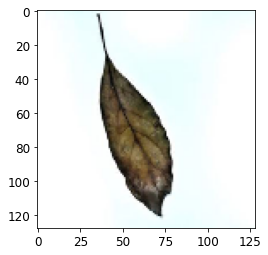

1/1 [==============================] - 0s 15ms/step
['NoSana', 'Sana']
[[0. 1.]]
Sana


In [25]:
from tensorflow.keras.preprocessing import image

#6 Hojas SANAS
#img=image.load_img("FotosCombinadas/Sana/augmented_13_3722550.jpeg",target_size=DEFAULT_IMAGE_SIZE)
#img=image.load_img("../FotosCombinadas/Sana/IMG_7912.jpeg",target_size=DEFAULT_IMAGE_SIZE)
#img=image.load_img("Fotos_Pruebas/hoja_sana_palto.jpeg",target_size=DEFAULT_IMAGE_SIZE)

#6 Hojas NO SANAS
#img=image.load_img("FotosCombinadas/NoSana/augmented_0_3427922.jpeg",target_size=DEFAULT_IMAGE_SIZE)
#img=image.load_img("../FotosCombinadas/NoSana/IMG_7925.jpeg",target_size=DEFAULT_IMAGE_SIZE)
img=image.load_img("Fotos_Pruebas/hoja_nosana_palto.jpeg",target_size=DEFAULT_IMAGE_SIZE)

plt.imshow(img)
plt.show()

x=image.img_to_array(img)
x=np.expand_dims(x,axis=0)
images=np.vstack([x])
pred=model.predict(images,batch_size=16)
#pred.shape
print(etiquetas)
print(pred)
if pred[0][0]>0.5:
    category="No Sana"
elif pred[0][1]>0.5:
    category="Sana"
        
print(category)